# Inverter Availability

In [ ]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')

import rdtools
print(rdtools.__version__)
print(rdtools.__file__)
import pandas as pd
import numpy as np
import pvlib

from rdtools import losses

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)


1.2.0+171.g8a3c58a.dirty
..\rdtools\__init__.py


## Get some test data

In [3]:
# make up some test clear-sky meter power data
st = '2019-01-03 00:00'
ed = '2019-01-09 00:00'
kWdc = 100.0
gamma = -0.004
lat, lon = 40, -80
tilt = 20
azi = 180
idx = pd.date_range(st, ed, freq='15T', closed='left', tz='US/Eastern')
location = pvlib.location.Location(lat, lon)
solpos = location.get_solarposition(idx)
clearsky = location.get_clearsky(idx, solar_position=solpos)
poa = pvlib.irradiance.get_total_irradiance(tilt,
                                            azi,
                                            solpos['zenith'],
                                            solpos['azimuth'],
                                            clearsky['dni'],
                                            clearsky['ghi'],
                                            clearsky['dhi'])
poa = poa['poa_global']
is_daylight = solpos['elevation'] > 0
tamb = pd.Series(index=idx, data=25)
tcell = pvlib.pvsystem.sapm_celltemp(poa, 0, tamb)
tcell = tcell['temp_cell']

power = poa/1000 * (1 + gamma*(tcell - 25))
inverter_power = pd.DataFrame({
    'inv0': (100.0 * power).clip(upper=50), 
    'inv1': (150.0 * power).clip(upper=75)
})

expected_power = inverter_power.sum(axis=1)
production_profile = losses.signal_to_profile(expected_power)

# real downtime
inverter_power.loc['2019-01-03', 'inv0'] = 0
inverter_power.loc['2019-01-05 10:00' : '2019-01-05 14:00', 'inv1'] = 0
inverter_power.loc['2019-01-07 12:00' : '2019-01-08 10:00', :] = 0

# just a comms outage on the inverters
inverter_power.loc['2019-01-06'] = 0

meter = inverter_power.sum(axis=1)
meter['2019-01-06'] = expected_power['2019-01-06']

## Detect inverter outages

In [4]:
online_mask = losses.is_online(inverter_power, meter)

Text(0, 0.5, 'Inverter Status')

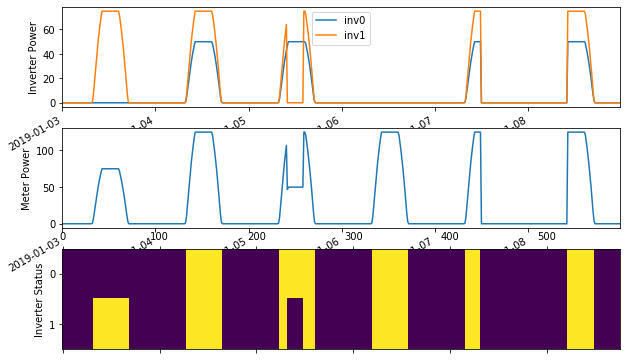

In [5]:
fig, ax = plt.subplots(3, 1)
inverter_power.plot(ax=ax[0])
ax[0].set_ylabel('Inverter Power')

meter.plot(ax=ax[1])
ax[1].set_ylabel('Meter Power')

plt.sca(ax[2])
plt.matshow(online_mask.T, aspect='auto', fignum=0)
ax[2].set_ylabel('Inverter Status')

In [6]:
lost_power = losses.downtime_loss(inverter_power, meter, online_mask, expected_power, production_profile, is_daylight)

Text(0, 0.5, 'Meter Power')

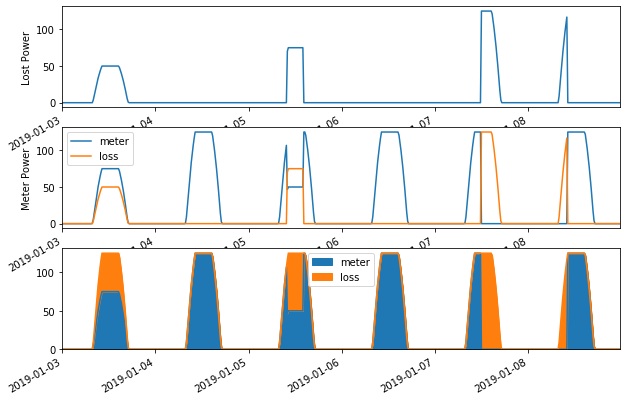

In [7]:
fig, ax = plt.subplots(3, 1)
lost_power.plot(ax=ax[0])
ax[0].set_ylabel('Lost Power')

df = pd.DataFrame({
    'meter': meter,
    'loss': lost_power
})
df.plot(ax=ax[1])
ax[1].set_ylabel('Meter Power')

df.plot.area(ax=ax[2])
ax[1].set_ylabel('Meter Power')
